In [ ]:
import networkx as nx
import sympy
from itertools import combinations
from collections import defaultdict, Counter

class GraphPolynomials:
    def __init__(self, G):
        if not isinstance(G, nx.Graph):
            raise TypeError("Graph must be a networkx.Graph")
        self.G = G.copy()
        self.x = sympy.Symbol("x")
        self.y = sympy.Symbol("y")

    def chromatic_polynomial(self):
        def _compute(G):
            x = self.x

            if any(u == v for u, v in G.edges()):  
                return 0

            if G.number_of_edges() == 0:
                return x ** G.number_of_nodes()

            u, v = list(G.edges())[0]
            G_del = G.copy()
            G_del.remove_edge(u, v)

            G_con = nx.contracted_nodes(G.copy(), u, v, self_loops=False)

            return _compute(G_del) - _compute(G_con)

        return sympy.simplify(_compute(self.G))

    def m_polynomial(self):
        x, y = self.x, self.y
        G = self.G
        degree_pairs = defaultdict(int)

        for u, v in G.edges():
            du, dv = G.degree[u], G.degree[v]
            i, j = sorted((du, dv))  # ensure i ≤ j
            degree_pairs[(i, j)] += 1

        poly = sum(k * x**i * y**j for (i, j), k in degree_pairs.items())
        return sympy.simplify(poly)

    def nm_polynomial(self):
        x, y = self.x, self.y
        G = self.G
        degree_pairs = defaultdict(int)

        for u, v in G.edges():
            du, dv = G.degree[u], G.degree[v]
            i, j = sorted((du, dv))  # ensure i ≤ j
            degree_pairs[(i, j)] += 1

        poly = sum(k * x**i * y**j for (i, j), k in degree_pairs.items())
        return sympy.simplify(poly)

    def independence_polynomial(self):
        G = self.G
        x = self.x

        max_indep_set = nx.algorithms.approximation.maximum_independent_set(G)
        alpha = len(max_indep_set)
        nodes = list(G.nodes)
        s_k = [0] * (alpha + 1)

        for k in range(alpha + 1):
            for subset in combinations(nodes, k):
                if all(not G.has_edge(u, v) for u, v in combinations(subset, 2)):
                    s_k[k] += 1

        poly = sum(s_k[k] * x**k for k in range(alpha + 1))
        return sympy.simplify(poly)
    
    def matching_polynomial(self):
        G = self.G
        x = self.x
        n = G.number_of_nodes()

        # Get maximum matching size ν(G)
        max_matching = nx.algorithms.maximal_matching(G)
        nu = len(max_matching)

        m_k = [0] * (nu + 1)

        edges = list(G.edges())
        for k in range(nu + 1):
            for edge_set in combinations(edges, k):
                nodes_used = set()
                valid = True
                for u, v in edge_set:
                    if u in nodes_used or v in nodes_used:
                        valid = False
                        break
                    nodes_used.update((u, v))
                if valid:
                    m_k[k] += 1

        poly_expr = sum(
            (-1)**k * m_k[k] * x**(n - 2*k)
            for k in range(nu + 1)
        )

        return sympy.simplify(poly_expr)

In [84]:
from IPython.display import display
import pandas as pd

class GraphPartition:
    def __init__(self, G):
        if not isinstance(G, (nx.Graph, nx.MultiGraph)):
            raise TypeError("Graph must be a networkx.Graph or MultiGraph.")
        self.G = G.copy()

    def degree_partition(self, show=True):
        degree_counts = Counter(dict(self.G.degree()).values())
        df = pd.DataFrame(sorted(degree_counts.items()), columns=["Degree", "Count"])
        if show:
            display(df.style.hide(axis='index'))
        return df

    def distance_partition(self, show=True):
        lengths = dict(nx.floyd_warshall(self.G))
        dist_counter = defaultdict(int)

        for u in self.G.nodes():
            for v in self.G.nodes():
                if u < v:
                    d = lengths[u][v]
                    if d != float('inf'):
                        dist_counter[d] += 1

        df = pd.DataFrame(sorted(dist_counter.items()), columns=["Distance", "Count"])
        if show:
            display(df.style.hide(axis='index'))
            return None
        return df
    
    def degree_pair_partition(self, show=True):
        degree_pairs = defaultdict(int)

        for u, v in self.G.edges():
            du, dv = self.G.degree[u], self.G.degree[v]
            i, j = sorted((du, dv))  # ensure i ≤ j
            degree_pairs[(i, j)] += 1

        df = pd.DataFrame(
            sorted(((i, j, c) for (i, j), c in degree_pairs.items())),
            columns=["deg(u)", "deg(v)", "Count"]
        )

        if show:
            display(df.style.hide(axis='index'))
            return None
        return df

In [85]:
G = nx.cycle_graph(7)
gp = GraphPolynomials(G)
gp.matching_polynomial()

x*(x**6 - 7*x**4 + 14*x**2 - 7)

In [86]:
gp2 = GraphPartition(G)
gp2.degree_pair_partition()

deg(u),deg(v),Count
2,2,7


In [87]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

class GraphPolynomialPlotter:
    def __init__(self, poly, var1, var2):
        if not isinstance(poly, sympy.Expr):
            raise TypeError("poly must be a sympy expression.")
        self.poly = poly
        self.var1 = var1
        self.var2 = var2

    def plot_surface(self, xlim=(0, 6), ylim=(0, 6), resolution=50, title="3D Polynomial Surface"):
        f = sympy.lambdify((self.var1, self.var2), self.poly, modules="numpy")

        x_vals = np.linspace(*xlim, resolution)
        y_vals = np.linspace(*ylim, resolution)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = f(X, Y)

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="k", alpha=0.9)

        ax.set_xlabel(f"{self.var1}")
        ax.set_ylabel(f"{self.var2}")
        ax.set_zlabel("Value")
        ax.set_title(title)
        plt.tight_layout()
        plt.show()

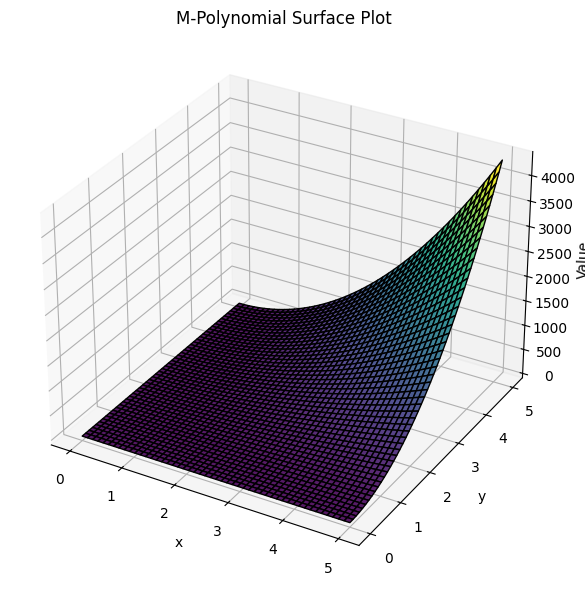

In [88]:
poly = gp.m_polynomial()
plotter = GraphPolynomialPlotter(poly, gp.x, gp.y)
plotter.plot_surface(xlim=(0, 5), ylim=(0, 5), title="M-Polynomial Surface Plot")